In [1]:
import pandas as pd 
import numpy as np
import math
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split , cross_val_score
from sklearn.linear_model import LogisticRegression

In [2]:
# Read in our data Frame
def readcsv(file_path):
    LARGE_FILE = file_path
    CHUNKSIZE = 100000 # processing 100,000 rows at a time
    # Add encoding encoding = "ISO-8859-1", why?
    reader = pd.read_csv(LARGE_FILE, chunksize=CHUNKSIZE, low_memory=False, encoding = "ISO-8859-1")
    frames = []
    for df in reader:
        frames.append(df)
    loan_data = pd.concat(frames)
    return loan_data   


# In[6]:

print('Start Reading')
FILE_PATH = "loan_data_no_current_converted.csv"
loan_data = readcsv(FILE_PATH)
print('Data Imported')

Start Reading
Data Imported


In [3]:
loan_data.shape

(891823, 145)

In [280]:
# Read in our data Frame
def readcsv(file_path):
    LARGE_FILE = file_path
    CHUNKSIZE = 100000 # processing 100,000 rows at a time
    # Add encoding encoding = "ISO-8859-1", why?
    reader = pd.read_csv(LARGE_FILE, chunksize=CHUNKSIZE, low_memory=False, encoding = "ISO-8859-1")
    frames = []
    for df in reader:
        frames.append(df)
    loan_data = pd.concat(frames)
    return loan_data   


# In[6]:

print('Start Reading')
FILE_PATH = "loan_data_no_current_converted.csv"
loan_data = readcsv(FILE_PATH)
print('Data Imported')

# In[7]:


df = loan_data.copy()


# In[8]:


# Convert Verification_status_joint, add this categorical data to the categorical list
for idx, i in df["verification_status_joint"].iteritems():
    if i == "Verified":
        df.at[idx, "verification_status_joint"] = 1
    elif i == "Source Verified":
        df.at[idx, "verification_status_joint"] = 2
    elif i == "Not Verified":
        df.at[idx, "verification_status_joint"] = 3


# In[9]:


categorical = ['grade', 'sub_grade', 'emp_length', 'purpose', 'title', 'application_type', 'hardship_flag', 'hardship_type', 'hardship_reason', 
              'hardship_status', 'hardship_loan_status', 'settlement_status', 'disbursement_method', 'home_ownership',
              'pymnt_plan', 'debt_settlement_flag', 'title', 'initial_list_status', 'loan_status', 'verification_status',
              'term', 'verification_status_joint']


# In[10]:


print("There are %d categorical data in our dataset." % len(categorical))


# # Feature Engineering

# In[11]:


# Read in engineered features.
FE_PATH = "This_week_FE.csv"
df_FE = readcsv(FE_PATH)
# temp.replace(float('nan'), -9999999, inplace =True)
# temp = df_FE[df_FE['ratio_rev_acct']!='#DIV/0!']


# In[12]:


df_FE['ratio_rev_acct'].replace('#DIV/0!', float(-np.inf), inplace = True)
df_FE.loc[:,'ratio_rev_acct'] = [float(x) for x in df_FE['ratio_rev_acct']]

df_FE['ratio_rev_acct'].replace(float(-np.inf), np.max(df_FE['ratio_rev_acct']), inplace = True)


# In[13]:


type(df_FE['loan_amt_to_avg_inc'][0])


# In[14]:


# Replace '#DIV/0!' with the max of each col
for i in df_FE.columns[0:3]:
    df_FE[i].replace('#DIV/0!', np.max(df_FE[i]), inplace = True)
    df_FE.loc[:,i] = [float(x) for x in df_FE[i]]

    print(i)

df = pd.concat([df,df_FE],axis=1)
assert(df_FE.shape[0] == df.shape[0])


# In[15]:


# 我写了一堆code 然后发现其实简单一点就能弄出来，所以大家忽略后面的code！！！
# I have wrote a lot of code for this only to find out that I only need this simple function!!!
def norm_inc_by_zip(zipcode, income):
    '''
        @description: Use on a column of data; output a dictionary that returns mean and average in each zipcode area
        @zipcode： zipcode dataframe column
        @income: income df column 
        @return:      return a dictionary
    '''  
    # I try to replace nan with 0 for income, and nan in zipcode for "000xx"
    df["annual_inc"].fillna(0)
    df["zip_code"].fillna("000xx")
    
    mean_var = {}
    for idx, value in zipcode.iteritems():
        # calculate total income
        if value in mean_var:
            mean_var[value].append(income[idx])
        else:
            mean_var[value] = [income[idx]]

    
    #assert(len(zip_code) == len(mean_var))
    # compute the average income in each zip_code area
    for key, value in mean_var.items():
        # if there only one element, we set their variance to 1. This way when normalize, it will have a 0 z-score.
        if len(value) == 1:
            #print(value[0])
            mean_var[key] = [value[0], 1]
        else:
            mean_var[key] = [np.mean(value), np.std(value)]
        
    # first loop through every annual income by calculate its z score. (Income - mean_by_zipcode) / variance_by_zipcode
    for idx, value in df["zip_code"].iteritems():
        #inc_colnum = df.columns.get_loc("annual_inc")
        col_num_inc = df["annual_inc"]
        mean, std = mean_var[value]
        df.at[idx, "annual_inc"] = (df.at[idx, "annual_inc"] - mean) / std
    print("Income is successfually normalized")
    return mean_var


# In[16]:


dic = norm_inc_by_zip(df["zip_code"], df["annual_inc"])
df.drop('zip_code', axis=1,inplace= True)


# # III. Set, X, Y, Train/Test Sets And normalize it accordingly

# In[17]:


def percentage(x):
    x = np.str(x)
    if x[-1] == '%':
        x = x[0:len(x)-1]
    return float(x) / 100


df['revol_util'] = [percentage(x) for x in df['revol_util']]


# In[18]:


# drop the observation that was missing for any field
df.dropna(axis=0, how='all', inplace=True)
df.dropna(axis=1, how='all', inplace=True)
# Use Finalized droplist provide by Yufei Gao
drop_list=['installment','term','settlement_date','pymnt_plan','hardship_length', 'settlement_percentage', 'settlement_term', 'sec_app_earliest_cr_line','policy_code','hardship_end_date','settlement_amount',
           'payment_plan_start_date','hardship_start_date','out_prncp','emp_title','title','earliest_cr_line','desc','issue_d','id','member_id','url','grade','sub_grade',
                   'int_rate','avg_cur_bal','out_prncp_inv','debt_settlement_flag_date','hardship_amount','hardship_reason','addr_state','funded_amnt','funded_amnt_inv','collection_recovery_fee',
                   'collections_12_mths_ex_med','mths_since_last_major_derog','next_pymnt_d','recoveries','total_pymnt',
                   'total_pymnt_inv','total_rec_int','last_pymnt_d','last_credit_pull_d',
                  'total_rec_prncp','settlement_status','hardship_loan_status','hardship_status','debt_settlement_flag',
                   'verification_status','total_rec_late_fee','verification_status_joint','hardship_flag', 'hardship_type', 'hardship_reason'
                    'hardship_status','hardship_loan_status','acc_now_delinq','delinq_amnt','deferral_term','hardship_amount'
                    'hardship_length','hardship_dpd','hardship_payoff_balance_amount','hardship_last_payment_amount']


# Drop drop_updated
df.drop(drop_list, inplace=True, axis=1, errors='ignore')

# Drop all colums where value missed more than 20%
num_rows=df.count(axis=0)
df=df.iloc[:,(num_rows>=0.8*len(df)).tolist()]

# Then fill rest of missing value with mean
df.fillna(df.mean(), inplace=True)
# Drop all rows with 4,5,6
'''for idx, i in loan_data["loan_status"].iteritems():
    if i == "Fully Paid":
        loan_data.at[idx, "loan_status"] = 1
    elif i == "Does not meet the credit policy. Status:Fully Paid":
        loan_data.at[idx, "loan_status"] = 2
    elif i == "Does not meet the credit policy. Status:Charged Off":
        loan_data.at[idx, "loan_status"] = 3
    elif i == "In Grace Period":
        loan_data.at[idx, "loan_status"] = 4
    elif i == "Late (16-30 days)":
        loan_data.at[idx, "loan_status"] = 5
    elif i == "Late (31-120 days)":
        loan_data.at[idx, "loan_status"] = 6
    elif i == "Default":
        loan_data.at[idx, "loan_status"] = 7
    elif i == "Charged Off":
        loan_data.at[idx, "loan_status"] = 8'''


# Let's test our result previous result, Previous result set Y to binary number 1,2.
# 4,5,6 are dropped, and we dont care about ‘Credit policy'
df = df[(df['loan_status']!=4) & (df['loan_status']!=5) & (df['loan_status']!=6)]
print("Input Dataset size is : ",df.shape)


# In[19]:


for i in df['revol_util']:
    if math.isnan(i):
        print(i)


# In[20]:


# Select features that is not in categorical data to normalize: categorial[], verification_status_joint, and annual_inc
# There categorical features are features need to include in X
features= list(df.columns)
features_need_norm = []
categorical_features = []
for i in features:
    if i not in categorical and i != "verification_status_joint":
        features_need_norm.append(i)
    else:
        categorical_features.append(i)



# In[21]:


print("There are %d numerical features need normalization" %len(features_need_norm))


# In[22]:


Y = df.loc[:,['loan_status']].values
features.remove("loan_status")
categorical_features.remove('loan_status')


# In[23]:


# We can not have loan_status in X, we want to check this, if it prints "Warning", we have a problem!!!
for i in categorical_features:
    if i == "loan_status":
        print("Warning!")
for i in features_need_norm:
    if i == "loan_status":
        print("Warning!")


# In[24]:


# Let's test our result previous result, Previous result set Y to binary number 1,2.

Y = list(Y.reshape(len(Y)))
for i in range(len(Y)):
    if Y[i]==7 or Y[i]==8 or Y[i] == 3:
        Y[i] = 1 # Default
    else:
        Y[i] = 0 # Fully Paid
        


# In[25]:


for i in Y:
    if i != 0 and i!=1:
        print(i)
        break


# In[26]:


# I want to find the starting index and ending index of categorical data in X. 
# starting_col_index_of_categorical_data: starting index of categorical data in X
# last_col_index_in_X: ending index of categorical data in X
X = df.loc[:,features_need_norm].values
starting_col_index_of_categorical_data = X.shape[1] 


# In[27]:


# df.loc[:,categorical_features].values.shape = (891823, 16)
X = np.concatenate((X, df.loc[:,categorical_features].values), axis=1)
last_col_index_in_X = X.shape[1]-1
# X.shape = (891823, 109)


# In[28]:


print("Number of categorical featurs in dataset:", len(categorical_features))
print("Number of numerical features in dataset:", len(features_need_norm))
# From column index 93 to column index 107 are 15 categorical data in X
# len(categorical_features) = 15
last_col_index_in_X-starting_col_index_of_categorical_data+1 == len(categorical_features)


# In[29]:


# split train test set 
Y = np.ravel(Y)

x_train, x_test, y_train, y_test = train_test_split(X,Y,random_state=1, test_size=0.25)
# x_train, x_test, y_train, y_test = log_reg.split(X,Y,rand=None)


# In[30]:


print("shape of x_train: ", x_train.shape)
print("shape of x_test: ", x_test.shape)
print("shape of y_train:", y_train.shape)
print("shape of y_test:", y_test.shape)


# # III. Normalize Train set and set mean variance in a dictionary:

# In[31]:


def normalize(numerical_features):
    '''
        @description: normalize all numerical features in X, and return a dictionary with mean variance of each features
        @numerical_features： a numpy array of numerical features of shape (668867, 79)
        @return: a dictionary contain mean variance of each features
    '''  
        # Step1: calculate mean variance of each columns in numerical features
    epsilon = 10**-8
    dic = {}
    counter = 0
    for columns in numerical_features.T:
        mean  = np.mean(columns)
        std = np.std(columns)
        dic[counter] = [mean, std]
        counter +=1

    assert(counter == numerical_features.shape[1])

    # Step2: Normalize numerical_features
    for key, val in dic.items():
        try :
        #numerical_features[:,key] = (numerical_features[:,key] - val[0]) / val[1]
            numerical_features[:, key] = (numerical_features[:,key] - val[0]) / val[1]
            assert(np.mean(numerical_features[:, key])- 0.0 < epsilon)
            assert(np.std(numerical_features[:, key])- 1.0 < epsilon)
        except AssertionError:
            print(np.mean(numerical_features[:, key])," | ", np.std(numerical_features[:, key]))
            print(numerical_features[:,key], "Key: ", key)
            print("SUM: ", np.sum(numerical_features[:, key]))
    return dic

            


# In[32]:


a = np.array([[1,2,3,4,5],[6,7,8,9,10]])
normalize(a)


# In[33]:


mv_dic = normalize(x_train[:,0: starting_col_index_of_categorical_data])


# In[34]:


# Normalize test set according to train set's mean variance
for key,val in mv_dic.items():
    x_test[:, key] = (x_test[:,key] - val[0] ) / val[1]
    # print(np.mean(x_test[:, key]))
    # print(np.std(x_test[:, key]))


# In[35]:


counter = 0
for i in y_test:
    if i==1:
        counter +=1
    
print('Train set ratio \n', counter/len(y_test), " | ", (len(y_test)-counter) / len(y_test))
    
counter = 0
for i in y_train:
    if i==1:
        counter +=1
    
print('Train set ratio \n', counter/len(y_train), " | ", (len(y_train)-counter) / len(y_train))
    


# In[36]:


df["loan_status"].value_counts()/ len(df)


# # IV. Train a Deep Learning Model

# # with tuned paramters
# 

# In[38]:


from keras.utils.np_utils import to_categorical
# Use small data set to test for overfitting
np.random.seed(1)
# rand_numbers = np.random.randint(0, len(x_train), int(len(x_train)*0.1))
# X_train = x_train[rand_numbers]
# X_test = x_test
# Y_train = y_train[rand_numbers]
# Y_test = y_test

X_train = x_train
X_test = x_test

Y_train = y_train
Y_test = y_test

print("shape of X_train: ", X_train.shape)
print("shape of X_test: ", X_test.shape)
print("shape of Y_train:", Y_train.shape)
print("shape of Y_test:", Y_test.shape)

Start Reading
Data Imported
There are 22 categorical data in our dataset.
season
loan_amt_to_avg_inc
coll_to_cur
Income is successfually normalized
Input Dataset size is :  (851641, 58)
There are 51 numerical features need normalization
Number of categorical featurs in dataset: 6
Number of numerical features in dataset: 51
shape of x_train:  (638730, 57)
shape of x_test:  (212911, 57)
shape of y_train: (638730,)
shape of y_test: (212911,)
Train set ratio 
 0.20687047639624068  |  0.7931295236037593
Train set ratio 
 0.2065348425782412  |  0.7934651574217588
shape of X_train:  (638730, 57)
shape of X_test:  (212911, 57)
shape of Y_train: (638730,)
shape of Y_test: (212911,)


In [281]:
class log_reg():
    # Evaluate the model by splitting into train and test sets
    def split(x,y,rand=0, test_size=0.25):
        
        y = np.ravel(y)
        x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=test_size,random_state=rand)
        
        return x_train, x_test, y_train, y_test 
    #we need to add validation dataset here
    
    # Find binary column method one
    def bool_cols(df,isbool=True):
        bool_cols=[]
        for col in df:
            if isbool==True:
                if df[col].dropna().value_counts().index.isin([0,1]).all():
                    bool_cols.append(col)
            else:
                if not df[col].dropna().value_counts().index.isin([0,1]).all():
                    bool_cols.append(col)
        return bool_cols
    # this above step is to facilitate normalization later
    # method two
    def not_bi(x):
        not_bi=[]
        for i in list(x):
            u=x[i].unique()
            if not (0 in u and 1 in u and len(u)==2): #if not binary
                not_bi.append(i)
        return not_bi
    
    def reg(x_train, y_train):
           
        #  Update for multiclass classification
        #model = LogisticRegression(penalty='l2',class_weight='balanced',solver='sag',n_jobs=-1)
        model = LogisticRegression(penalty='l2',class_weight='balanced',solver='saga',n_jobs=-1,)
        
#         weight = {1: 1.0, 2: 55.72585567010309, 3: 24.082261111309123, 4: 3.8398317847299177}
#         model = LogisticRegression(penalty='l2',class_weight=weight,solver='saga',n_jobs=-1,multi_class="ovr")


        
        """
        Why we need standardize?
        
        Note that ‘sag’ and ‘saga’ fast convergence is only guaranteed on features 
        with approximately the same scale. You can preprocess the data with 
        a scaler from sklearn.preprocessing.
        """
        
        model = model.fit(x_train, y_train)
        
        return model
    
    def ModelValuation(x_test,y_test,model):
        
        probs = model.predict_proba(x_test)
        fpr, tpr, thresholds = metrics.roc_curve(y_test, probs[:, 1])
        
        plt.figure(1)
        plt.plot(fpr, tpr, label='LogisticRegression')
        plt.xlabel('False positive rate')
        plt.ylabel('True positive rate')
        plt.title('ROC curve')
        plt.legend(loc='best')
        plt.show()
        
        print("Area Under the Curve (AUC) from prediction score is %f" % metrics.roc_auc_score(y_test, probs[:, 1]))
    
        return None  
    
    def y_pred(x_test,threshold=0.5):
        
        if threshold == 0.5:
            y_predicted = model.predict(x_test)
        else:
            probs = model.predict_proba(x_test)
            y_predicted = np.array(probs[:,1] >= threshold).astype(int)
        
        return y_predicted    
    
    def GetScores(y_test,y_predicted):
        #G means score 
        CM = metrics.confusion_matrix(y_test, y_predicted)
        TN = CM[0,0]
        FN = CM[1,0]
        TP = CM[1,1]
        FP = CM[0,1]
        
        sensitivity = float(TP)/float(TP+FN)
        specificity = float(TN)/float(TN+FP)
        G = np.sqrt(sensitivity*specificity)
        print("G score is %f" % G)
        print("Specificity is %f" % specificity)
        
        # Generate and display different evaluation metrics
        print("Mean accuracy score is %f" % metrics.accuracy_score(y_test, y_predicted))
          
        print("Confusion Marix")
        print(CM)
        
        return specificity , G
        
    # Convenience function to plot confusion matrix
    def confusion(y_test,y_predicted,title):
        
        # Define names for the three Iris types
        names = ['Not Default', 'Default']
    
        # Make a 2D histogram from the test and result arrays
        pts, xe, ye = np.histogram2d(y_test, y_predicted, bins=2)
    
        # For simplicity we create a new DataFrame
        pd_pts = pd.DataFrame(pts.astype(int), index=names, columns=names )
        
        # Display heatmap and add decorations
        hm = sns.heatmap(pd_pts, annot=True, fmt="d")
        hm.axes.set_title(title)
        
        return None
            
    def find_threshold(x_test,y_test):
    
        probs = model.predict_proba(x_test)
        fpr, tpr, thresholds = metrics.roc_curve(y_test, probs[:, 1])
        
        sensitivity = tpr
        specificity = 1 - fpr
        G = np.sqrt(sensitivity*specificity)
        
        plt.figure(2)
        plt.plot(thresholds,G)
        plt.xlabel('Thresholds')
        plt.ylabel('G-Scores')
        plt.title('G-Scores with different thresholds')
        plt.show()
        
        
        print("The highest G score is %f with threshold at %f" % (np.amax(G),thresholds[np.argmax(G)]) )
        
        return thresholds[np.argmax(G)]

In [282]:
# Load model V9 to continue training with same paramters.
from keras.models import load_model
model_dnn = load_model('binary_classification_V10.h5')

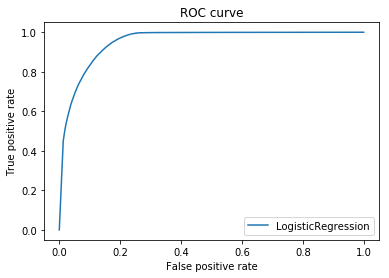

Area Under the Curve (AUC) from prediction score is 0.953250


In [283]:
log_reg.ModelValuation(X_test, Y_test, model_dnn)

G score is 0.837982
Specificity is 0.930531
Mean accuracy score is 0.894144
Confusion Marix
[[157135  11731]
 [ 10807  33238]]


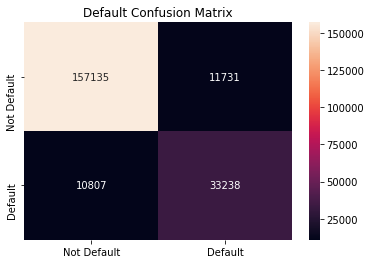

In [284]:
# Test Accuracy
y_predicted = model_dnn.predict_classes(X_test)
spec , G = log_reg.GetScores(Y_test,y_predicted)
log_reg.confusion(Y_test,y_predicted,'Default Confusion Matrix')

G score is 0.850594
Specificity is 0.934575
Mean accuracy score is 0.901443
Confusion Marix
[[473652  33158]
 [ 29793 102127]]


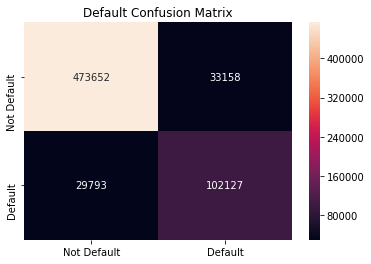

In [285]:
# Train Accuracy: 
y_predicted = model_dnn.predict_classes(X_train)
spec , G = log_reg.GetScores(Y_train,y_predicted)
log_reg.confusion(Y_train,y_predicted,'Default Confusion Matrix')

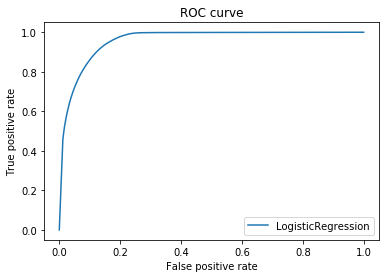

Area Under the Curve (AUC) from prediction score is 0.958079


In [286]:
log_reg.ModelValuation(X_train, Y_train, model_dnn)

# Make Predictions

In [287]:
# Load Current Dataset and make future predictions
print('Start Reading')
FILE_PATH = "./loan_data_all.csv"
curr_loan = readcsv(FILE_PATH)
print('Data Imported')

Start Reading
Data Imported


In [288]:
curr_loan = curr_loan[curr_loan['loan_status'] == 'Current']

In [289]:
loan_data = curr_loan.copy()
# string to categorical variables

In [290]:
loan_data["grade"].fillna(0, inplace=True)

for idx, i in loan_data["grade"].iteritems():
    if i == "A":
        loan_data.at[idx, "grade"] = 1
    elif i == "B":
        loan_data.at[idx, "grade"] = 2
    elif i == "C":
        loan_data.at[idx, "grade"] = 3
    elif i == "D":
        loan_data.at[idx, "grade"] = 4
    elif i == "E":
        loan_data.at[idx, "grade"] = 5
    elif i == "F":
        loan_data.at[idx, "grade"] = 6
    elif i == "G":
        loan_data.at[idx, "grade"] = 7
    

# SubGrade

dic = {}
for i in loan_data["sub_grade"]:
    if i in dic:
        dic[i] +=1
    else:
        dic[i] =1
print("number of category: ", len(dic))

dic

loan_data["sub_grade"].fillna(0, inplace=True)

for idx, i in loan_data["sub_grade"].iteritems():
    if i == "A1":
        loan_data.at[idx, "sub_grade"] = 1
    elif i == "A2":
        loan_data.at[idx, "sub_grade"] = 2
    elif i == "A3":
        loan_data.at[idx, "sub_grade"] = 3
    elif i == "A4":
        loan_data.at[idx, "sub_grade"] = 4
    elif i == "A5":
        loan_data.at[idx, "sub_grade"] = 5
    elif i == "B1":
        loan_data.at[idx, "sub_grade"] = 6
    elif i == "B2":
        loan_data.at[idx, "sub_grade"] = 7
    elif i == "B3":
        loan_data.at[idx, "sub_grade"] = 8
    elif i == "B4":
        loan_data.at[idx, "sub_grade"] = 9
    elif i == "B5":
        loan_data.at[idx, "sub_grade"] = 10
    elif i == "C1":
        loan_data.at[idx, "sub_grade"] = 11
    elif i == "C2":
        loan_data.at[idx, "sub_grade"] = 12
    elif i == "C3":
        loan_data.at[idx, "sub_grade"] = 13
    elif i == "C4":
        loan_data.at[idx, "sub_grade"] = 14
    elif i == "C5":
        loan_data.at[idx, "sub_grade"] = 15
    elif i == "D1":     
        loan_data.at[idx, "sub_grade"] = 16
    elif i == "D2":     
        loan_data.at[idx, "sub_grade"] = 17
    elif i == "D3":     
        loan_data.at[idx, "sub_grade"] = 18
    elif i == "D4":     
        loan_data.at[idx, "sub_grade"] = 19
    elif i == "D5":     
        loan_data.at[idx, "sub_grade"] = 20
    elif i == "E1":     
        loan_data.at[idx, "sub_grade"] = 21
    elif i == "E2":     
        loan_data.at[idx, "sub_grade"] = 22
    elif i == "E3":     
        loan_data.at[idx, "sub_grade"] = 23
    elif i == "E4":     
        loan_data.at[idx, "sub_grade"] = 24
    elif i == "E5":     
        loan_data.at[idx, "sub_grade"] = 25
    elif i == "F1":     
        loan_data.at[idx, "sub_grade"] = 26
    elif i == "F2":     
        loan_data.at[idx, "sub_grade"] = 27
    elif i == "F3":     
        loan_data.at[idx, "sub_grade"] = 28
    elif i == "F4":     
        loan_data.at[idx, "sub_grade"] = 29
    elif i == "F5":     
        loan_data.at[idx, "sub_grade"] = 30
    elif i == "G1":     
        loan_data.at[idx, "sub_grade"] = 31
    elif i == "G2":     
        loan_data.at[idx, "sub_grade"] = 32
    elif i == "G3":     
        loan_data.at[idx, "sub_grade"] = 33
    elif i == "G4":
        loan_data.at[idx, "sub_grade"] = 34
    elif i == "G5":     
        loan_data.at[idx, "sub_grade"] = 35

# emp_length adjustment

loan_data["emp_length"].fillna(0, inplace=True)

dic = {}
for i in loan_data["emp_length"]:
    if i in dic:
        dic[i] +=1
    else:
        dic[i] =1
print("number of category: ", len(dic))

dic

for idx, i in loan_data["emp_length"].iteritems():
    if i == '< 1 year':
        loan_data.at[idx, "emp_length"] = 0.5
    elif i == "1 year":
        loan_data.at[idx, "emp_length"] = 1
    elif i == '2 years':
        loan_data.at[idx, "emp_length"] = 2
    elif i == '3 years':
        loan_data.at[idx, "emp_length"] = 3
    elif i == '4 years':
        loan_data.at[idx, "emp_length"] = 4
    elif i == "5 years":
        loan_data.at[idx, "emp_length"] = 5
    elif i == "6 years":
        loan_data.at[idx, "emp_length"] = 6
    elif i == "7 years":
        loan_data.at[idx, "emp_length"] = 7
    elif i == '8 years':
        loan_data.at[idx, "emp_length"] = 8
    elif i == '9 years':
        loan_data.at[idx, "emp_length"] = 9
    elif i == '10+ years':
        loan_data.at[idx, "emp_length"] = 10
    elif i == 'n/a':
        loan_data.at[idx, "emp_length"] = 0

# purpose _ adjustment

dic = {}
for i in loan_data["purpose"]:
    if i in dic:
        dic[i] +=1
    else:
        dic[i] =1
print("number of category: ", len(dic))

dic

loan_data["purpose"].fillna(0, inplace=True)

for idx, i in loan_data["purpose"].iteritems():
    if i == "credit_card":
        loan_data.at[idx, "purpose"] = 1
    elif i == "car":
        loan_data.at[idx, "purpose"] = 2
    elif i == "small_business":
        loan_data.at[idx, "purpose"] = 3
    elif i == "other":
        loan_data.at[idx, "purpose"] = 4
    elif i == "wedding":
        loan_data.at[idx, "purpose"] = 5
    elif i == "debt_consolidation":
        loan_data.at[idx, "purpose"] = 6
    elif i == "home_improvement":
        loan_data.at[idx, "purpose"] = 7
    elif i == "major_purchase":
        loan_data.at[idx, "purpose"] = 8
    elif i == "medical":
        loan_data.at[idx, "purpose"] = 9
    elif i == "moving":
        loan_data.at[idx, "purpose"] = 10
    elif i == "vacation":
        loan_data.at[idx, "purpose"] = 11
    elif i == "house":
        loan_data.at[idx, "purpose"] = 12
    elif i == "renewable_energy":
        loan_data.at[idx, "purpose"] = 13
    elif i == "educational":
        loan_data.at[idx, "purpose"] = 14

# title_adjustment_PASSED

dic={}
for i in loan_data["title"]:
    if i in dic:
        dic[i]+=1
    else:
        dic[i]=1
print("number of category: ", len(dic))

# application_type adjustment

dic={}
for i in loan_data["application_type"]:
    if i in dic:
        dic[i]+=1
    else:
        dic[i]=1
print("number of category: ", len(dic))

dic

loan_data["application_type"].fillna(0, inplace=True)

for idx, i in loan_data["application_type"].iteritems():
    if i =="Individual":
        loan_data.at[idx,"application_type"]=1
    elif i=="Joint App":
        loan_data.at[idx,"application_type"]=2

# hardship_flag adjustment

dic={}
for i in loan_data["hardship_flag"]:
    if i in dic:
        dic[i]+=1
    else:
        dic[i]=1
print("number of category: ", len(dic))

dic

loan_data["hardship_flag"].fillna(0,inplace=True)

for idx, i in loan_data["hardship_flag"].iteritems():
    if i == "N":
        loan_data.at[idx,"hardship_flag"] = 2
    elif i == "Y":
        loan_data.at[idx,"hardship_flag"] = 1
    

# hardship_type adjustment

dic={}
for i in loan_data["hardship_type"]:
    if i in dic:
        dic[i]+=1
    else:
        dic[i]=1
print("number of category: ", len(dic))

dic

loan_data["hardship_type"].fillna(0,inplace=True)

for idx, i in loan_data["hardship_type"].iteritems():
    if i == "INTEREST ONLY-3 MONTHS DEFERRAL":
        loan_data.at[idx,"hardship_type"] = 1

# hardship_reason adjustment

dic={}
for i in loan_data["hardship_reason"]:
    if i in dic:
        dic[i]+=1
    else:
        dic[i]=1
print("number of category: ", len(dic))

dic

loan_data["hardship_reason"].fillna(0, inplace=True)

for idx, i in loan_data["hardship_reason"].iteritems():
    if i == "INCOME_CURTAILMENT":
        loan_data.at[idx, "hardship_reason"] = 1
    elif i == "MEDICAL":
        loan_data.at[idx, "hardship_reason"] = 2
    elif i == "NATURAL_DISASTER":
        loan_data.at[idx, "hardship_reason"] = 3
    elif i == "UNEMPLOYMENT":
        loan_data.at[idx, "hardship_reason"] = 4
    elif i == "EXCESSIVE_OBLIGATIONS":
        loan_data.at[idx, "hardship_reason"] = 5
    elif i == "FAMILY_DEATH":
        loan_data.at[idx, "hardship_reason"] = 6
    elif i == "REDUCED_HOURS":
        loan_data.at[idx, "hardship_reason"] = 7
    elif i == "DISABILITY":
        loan_data.at[idx, "hardship_reason"] = 8
    elif i == "DIVORCE":
        loan_data.at[idx, "hardship_reason"] = 9

# hardship_status adjustment

dic={}
for i in loan_data["hardship_status"]:
    if i in dic:
        dic[i]+=1
    else:
        dic[i]=1
print("number of category: ", len(dic))

dic

loan_data["hardship_status"].fillna(0,inplace=True)

for idx, i in loan_data["hardship_status"].iteritems():
    if i == "COMPLETED":
        loan_data.at[idx, "hardship_status"] = 1
    elif i == "BROKEN":
        loan_data.at[idx, "hardship_status"] = 2
    elif i == "ACTIVE":
        loan_data.at[idx, "hardship_status"] = 3

# hardship_loan_status adjustment

dic={}
for i in loan_data["hardship_loan_status"]:
    if i in dic:
        dic[i]+=1
    else:
        dic[i]=1
print("number of category: ", len(dic))

dic

for idx, i in loan_data["hardship_loan_status"].iteritems():
    if i == "Late (31-120 days)":
        loan_data.at[idx, "hardship_loan_status"] = 1
    elif i == "Current":
        loan_data.at[idx, "hardship_loan_status"] = 2
    elif i == "Late (16-30 days)":
        loan_data.at[idx, "hardship_loan_status"] = 3
    elif i == "In Grace Period":
        loan_data.at[idx, "hardship_loan_status"] = 4
    elif i == "Issued":
        loan_data.at[idx, "hardship_loan_status"] = 5


loan_data["hardship_loan_status"].fillna(0,inplace=True)

# settlement_status adjustment

dic={}
for i in loan_data["settlement_status"]:
    if i in dic:
        dic[i]+=1
    else:
        dic[i]=1
print("number of category: ", len(dic))

dic

loan_data["settlement_status"].fillna(0,inplace=True)

for idx, i in loan_data["settlement_status"].iteritems():
    if i == "COMPLETE":
        loan_data.at[idx, "settlement_status"] = 1
    elif i == "BROKEN":
        loan_data.at[idx, "settlement_status"] = 2
    elif i == "ACTIVE":
        loan_data.at[idx, "settlement_status"] = 3

# _disbursement_method adjustment

dic={}
for i in loan_data["disbursement_method"]:
    if i in dic:
        dic[i]+=1
    else:
        dic[i]=1
print ("number of category: ", len(dic))

dic

loan_data["disbursement_method"].fillna(0,inplace=True)

for idx, i in loan_data["disbursement_method"].iteritems():
    if i == "Cash":
        loan_data.at[idx,"disbursement_method"] = 1
    elif i == "DirectPay":
        loan_data.at[idx,"disbursement_method"] = 2


# home_ownership - adjustment

dic={}
for i in loan_data["home_ownership"]:
    if i in dic:
        dic[i]+=1
    else:
        dic[i]=1
print ("number of category: ", len(dic))

dic

loan_data["home_ownership"].fillna(0,inplace=True)

for idx, i in loan_data["home_ownership"].iteritems():
    if i == "RENT":
        loan_data.at[idx, "home_ownership"] = 1
    elif i == "OWN":
        loan_data.at[idx, "home_ownership"] = 2
    elif i == "MORTGAGE":
        loan_data.at[idx, "home_ownership"] = 3
    elif i == "OTHER":
        loan_data.at[idx, "home_ownership"] = 4
    elif i == "OWN":
        loan_data.at[idx, "home_ownership"] = 5
    elif i == "NONE":
        loan_data.at[idx, "home_ownership"] = 6
    elif i == "ANY":
        loan_data.at[idx, "home_ownership"] = 7

# pymnt_plan adjustment

dic={}
for i in loan_data["pymnt_plan"]:
    if i in dic:
        dic[i]+=1
    else:
        dic[i]=1
print ("number of category: ", len(dic))

dic

loan_data["pymnt_plan"].fillna(0,inplace=True)

for idx, i in loan_data["pymnt_plan"].iteritems():
    if i == "y":
        loan_data.at[idx, "pymnt_plan"] = 1
    elif i == "n":
        loan_data.at[idx, "pymnt_plan"] = 2

# debt_settlement_flag adjustment

dic={}
for i in loan_data["debt_settlement_flag"]:
    if i in dic:
        dic[i]+=1
    else:
        dic[i]=1
print ("number of category: ", len(dic))

dic

loan_data["debt_settlement_flag"].fillna(0,inplace=True)

for idx, i in loan_data["debt_settlement_flag"].iteritems():
    if i == "Y":
        loan_data.at[idx, "debt_settlement_flag"] = 1
    elif i == "N":
        loan_data.at[idx, "debt_settlement_flag"] = 2

# title - passed

dic={}
for i in loan_data["title"]:
    if i in dic:
        dic[i]+=1
    else:
        dic[i]=1
print ("number of category: ", len(dic))

# initial_list_status adjustment

dic={}
for i in loan_data["initial_list_status"]:
    if i in dic:
        dic[i]+=1
    else:
        dic[i]=1
print ("number of category: ", len(dic))

dic

loan_data["initial_list_status"].fillna(0,inplace=True)

for idx, i in loan_data["initial_list_status"].iteritems():
    if i == "f":
        loan_data.at[idx, "initial_list_status"] = 1
    elif i == "w":
        loan_data.at[idx, "initial_list_status"] = 2

# loan_status adjustment

dic={}
for i in loan_data["loan_status"]:
    if i in dic:
        dic[i]+=1
    else:
        dic[i]=1
print ("number of category: ", len(dic))

dic

loan_data["loan_status"].fillna(0,inplace=True)

for idx, i in loan_data["loan_status"].iteritems():
    if i == "Fully Paid":
        loan_data.at[idx, "loan_status"] = 1
    elif i == "Does not meet the credit policy. Status:Fully Paid":
        loan_data.at[idx, "loan_status"] = 2
    elif i == "Does not meet the credit policy. Status:Charged Off":
        loan_data.at[idx, "loan_status"] = 3
    elif i == "In Grace Period":
        loan_data.at[idx, "loan_status"] = 4
    elif i == "Late (16-30 days)":
        loan_data.at[idx, "loan_status"] = 5
    elif i == "Late (31-120 days)":
        loan_data.at[idx, "loan_status"] = 6
    elif i == "Default":
        loan_data.at[idx, "loan_status"] = 7
    elif i == "Charged Off":
        loan_data.at[idx, "loan_status"] = 8
    elif i == "Current":
        loan_data.at[idx, "loan_status"] = 9


# verification_status adjustment

dic={}
for i in loan_data["verification_status"]:
    if i in dic:
        dic[i]+=1
    else:
        dic[i]=1
print ("number of category: ", len(dic))

dic

loan_data["verification_status"].fillna(0,inplace=True)

for idx, i in loan_data["verification_status"].iteritems():
    if i == "Verified":
        loan_data.at[idx, "verification_status"] = 1
    elif i == "Source Verified":
        loan_data.at[idx, "verification_status"] = 2
    elif i == "Not Verified":
        loan_data.at[idx, "verification_status"] = 3

# term adjustment

dic={}
for i in loan_data["term"]:
    if i in dic:
        dic[i]+=1
    else:
        dic[i]=1
print ("number of category: ", len(dic))

dic

loan_data["term"].fillna(0,inplace=True)

for idx, i in loan_data["term"].iteritems():
    if i == " 36 months":
        loan_data.at[idx, "term"] = 1
    elif i == " 60 months":
        loan_data.at[idx, "term"] = 2

number of category:  35
number of category:  12
number of category:  14
number of category:  2614
number of category:  2
number of category:  2
number of category:  2
number of category:  10
number of category:  4
number of category:  6
number of category:  3
number of category:  2
number of category:  5
number of category:  2
number of category:  2
number of category:  2614
number of category:  2
number of category:  1
number of category:  3
number of category:  2


In [291]:
# Drop all listed columns:
# 1. Found all columns left in training dataset
DF_CONST = df.copy()

In [361]:
# Preprocess curr_loan
df = loan_data.copy()

# Convert Verification_status_joint, add this categorical data to the categorical list
for idx, i in df["verification_status_joint"].iteritems():
    if i == "Verified":
        df.at[idx, "verification_status_joint"] = 1
    elif i == "Source Verified":
        df.at[idx, "verification_status_joint"] = 2
    elif i == "Not Verified":
        df.at[idx, "verification_status_joint"] = 3


# In[9]:


categorical = ['grade', 'sub_grade', 'emp_length', 'purpose', 'title', 'application_type', 'hardship_flag', 'hardship_type', 'hardship_reason', 
              'hardship_status', 'hardship_loan_status', 'settlement_status', 'disbursement_method', 'home_ownership',
              'pymnt_plan', 'debt_settlement_flag', 'title', 'initial_list_status', 'loan_status', 'verification_status',
              'term', 'verification_status_joint']


print("There are %d categorical data in our dataset." % len(categorical))



There are 22 categorical data in our dataset.


In [362]:
def norm_inc_by_zip(zipcode, income):
    '''
        @description: Use on a column of data; output a dictionary that returns mean and average in each zipcode area
        @zipcode： zipcode dataframe column
        @income: income df column 
        @return:      return a dictionary
    '''  
    # I try to replace nan with 0 for income, and nan in zipcode for "000xx"
    df["annual_inc"].fillna(0)
    df["zip_code"].fillna("000xx")
    
    mean_var = {}
    for idx, value in zipcode.iteritems():
        # calculate total income
        if value in mean_var:
            mean_var[value].append(income[idx])
        else:
            mean_var[value] = [income[idx]]

    
    #assert(len(zip_code) == len(mean_var))
    # compute the average income in each zip_code area
    for key, value in mean_var.items():
        # if there only one element, we set their variance to 1. This way when normalize, it will have a 0 z-score.
        if len(value) == 1:
            #print(value[0])
            mean_var[key] = [value[0], 1]
        else:
            mean_var[key] = [np.mean(value), np.std(value)]
        
    # first loop through every annual income by calculate its z score. (Income - mean_by_zipcode) / variance_by_zipcode
    for idx, value in df["zip_code"].iteritems():
        #inc_colnum = df.columns.get_loc("annual_inc")
        col_num_inc = df["annual_inc"]
        mean, std = mean_var[value]
        df.at[idx, "annual_inc"] = (df.at[idx, "annual_inc"] - mean) / std
    print("Income is successfually normalized")
    return mean_var


# In[16]:


dic = norm_inc_by_zip(df["zip_code"], df["annual_inc"])
# df.drop('zip_code', axis=1,inplace= True)


# # III. Set, X, Y, Train/Test Sets And normalize it accordingly

# In[17]:


def percentage(x):
    x = np.str(x)
    if x[-1] == '%':
        x = x[0:len(x)-1]
    return float(x) / 100


df['revol_util'] = [percentage(x) for x in df['revol_util']]


/Users/zhejianpeng/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in double_scalars


Income is successfually normalized


In [363]:
# Set Season 
def season_helper(x):
    # input is string
    if 'Jan' in i:
        return 1
    elif 'Feb' in i:
        return 2
    elif 'Mar' in i:
        return 3
    elif 'Apr' in i:
        return 4
    elif 'May' in i:
        return 5
    elif 'Jun' in i:
        return 6
    elif 'Jul' in i:
        return 7
    elif 'Aug' in i:
        return 8
    elif 'Sep' in i:
        return 9
    elif 'Oct' in i:
        return 10
    elif 'Nov' in i:
        return 11
    elif 'Dec' in i:
        return 12
    
temp = []
for i in df['issue_d']:
    temp.append(season_helper(i[0:3]))
# temp = [season_helper(str(x)[0:3]) for x in df['issue_d']]
df['season'] = temp
# pd.unique(df['issue_d'])

In [365]:
def zip_helper(x):
    return dic[x][0]
df['avg_inc_zip'] = [zip_helper(x) for x in df['zip_code']]
df['loan_amt_to_avg_inc'] = df['loan_amnt'] / df['avg_inc_zip']

In [366]:
df['coll_to_cur'] = df['tot_coll_amt'] / df['tot_cur_bal'] 
df['ratio_rev_acct'] = df['num_rev_tl_bal_gt_0'] / df['num_rev_accts']

In [367]:
df = df[DF_CONST.columns]

In [368]:
df['ratio_rev_acct'].replace(np.nan, float(-np.inf), inplace = True)
df.loc[:,'ratio_rev_acct'] = [float(x) for x in df['ratio_rev_acct']]

df['ratio_rev_acct'].replace(float(-np.inf), np.max(df['ratio_rev_acct']), inplace = True)

/Users/zhejianpeng/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:3924: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)
/Users/zhejianpeng/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [369]:
type(df['loan_amt_to_avg_inc'].iloc[0])
engr_features= ['loan_amt_to_avg_inc', 'season', 'coll_to_cur']

In [370]:
# Replace '#DIV/0!' with the max of each col
for i in engr_features:
    df[i].replace(np.inf, sorted(list(set(df['coll_to_cur'])))[-2], inplace = True)
    # df[i].replace(np.nan, np.max(df[i]), inplace = True)
    df.loc[:,i] = [float(x) for x in df[i]]
    print(i)



/Users/zhejianpeng/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:3924: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)
/Users/zhejianpeng/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


loan_amt_to_avg_inc
season
coll_to_cur


In [371]:
df.fillna(df.mean(), inplace=True)
print('DONE')

/Users/zhejianpeng/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:3660: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


DONE


In [376]:
# Select features that is not in categorical data to normalize: categorial[], verification_status_joint, and annual_inc
# There categorical features are features need to include in X
features= list(df.columns)
features_need_norm = []
categorical_features = []
for i in features:
    if i not in categorical and i != "verification_status_joint":
        features_need_norm.append(i)
    else:
        categorical_features.append(i)



# In[21]:


print("There are %d numerical features need normalization" %len(features_need_norm))


# In[22]:


Y = df.loc[:,['loan_status']].values
features.remove("loan_status")
categorical_features.remove('loan_status')


# In[23]:


# We can not have loan_status in X, we want to check this, if it prints "Warning", we have a problem!!!
for i in categorical_features:
    if i == "loan_status":
        print("Warning!")
for i in features_need_norm:
    if i == "loan_status":
        print("Warning!")


# In[24]:


# Let's test our result previous result, Previous result set Y to binary number 1,2.

Y = list(Y.reshape(len(Y)))
for i in range(len(Y)):
    if Y[i]==7 or Y[i]==8 or Y[i] == 3:
        Y[i] = 1 # Default
    else:
        Y[i] = 0 # Fully Paid
        


# In[25]:


for i in Y:
    if i != 0 and i!=1:
        print(i)
        break


# In[26]:


# I want to find the starting index and ending index of categorical data in X. 
# starting_col_index_of_categorical_data: starting index of categorical data in X
# last_col_index_in_X: ending index of categorical data in X
X = df.loc[:,features_need_norm].values
starting_col_index_of_categorical_data = X.shape[1] 


# In[27]:


# df.loc[:,categorical_features].values.shape = (891823, 16)
X = np.concatenate((X, df.loc[:,categorical_features].values), axis=1)
last_col_index_in_X = X.shape[1]-1
# X.shape = (891823, 109)


# In[28]:


print("Number of categorical featurs in dataset:", len(categorical_features))
print("Number of numerical features in dataset:", len(features_need_norm))
# From column index 93 to column index 107 are 15 categorical data in X
# len(categorical_features) = 15
last_col_index_in_X-starting_col_index_of_categorical_data+1 == len(categorical_features)

There are 51 numerical features need normalization
Number of categorical featurs in dataset: 6
Number of numerical features in dataset: 51


True

In [377]:
'''from sklearn import preprocessing
scaler = preprocessing.StandardScaler().fit(X)
X_pred = scaler.transform(X)                           
'''

'from sklearn import preprocessing\nscaler = preprocessing.StandardScaler().fit(X)\nX_pred = scaler.transform(X)                           \n'

In [380]:
print('Predict %d loans\' status'% X.shape[0])
# Test Accuracy
y_predicted = model_dnn.predict_classes(X_train)
       

Predict 873603 loans' status


In [381]:
print("According to or model, there is going to be %f percent of loans will default out of\
 873603 loans" %(sum(y_predicted) / len(y_predicted)))

According to or model, there is going to be 0.211803 percent of loans will default out of 873603 loans
